# Popularity Prediction

Considering that Spotify has has over 175,000 songs in its catalogue, it is a lot to comb through. The data analysis on the dataset's features were seen in the notebooks of univariate and bivariate analysis. The aim of this notebook is to utilize various different machine learning techniques to attempt to predict the popularity level based on the other features of the data set.

In [2]:
# Import necessary libraries for data manipulation
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import necessary libraries for predictions
from scipy.optimize import curve_fit
from sklearn.preprocessing import FunctionTransformer
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.compose import ColumnTransformer
from six import StringIO
import statsmodels.api as sm

# Import necessary libraries for scoring
from sklearn.metrics import mean_squared_error as mse

# Import necessary libraries for validation
from sklearn.model_selection import train_test_split as split

print('Libraries Imported')

Libraries Imported


In [3]:
# Import Spotify Tracks Dataset
df = pd.read_csv('/home/jovyan/demo/data/Spotify Data.csv')
print('Dataset Imported')

Dataset Imported


# Cleaning

Based on the previous univariate and bivariate analysis there are some features that would not aid us in creating our predictive models. 

- id: The id is unique for every song. This feature will be dropped.
- name: This is the name for each song. This could cause potential problems within model building and therefore will be dropped.
 - artists: We can assume that an artist will impact the modeling of the tracks popularity level. Since there will be artists that have multiple tracks the duplicates will be removed.
  - release_date/year: The year feature will be kept and the release_date will be dropped

In [4]:
# Convert release_date feature from object to date time
df['release_date'] = pd.to_datetime(df['release_date'])

# Create new column based solely on the year of date time
df['year'] = df['release_date'].dt.year

# Convert duration_ms to duration measured in seconds
df['duration'] = round(df['duration_ms']/(1000 * 60),2)

# Drop old release_date column
df = df.drop(columns = ['release_date', 'id', 'name', 'artists', 'duration_ms'], axis = 1, inplace = False)

# View new data set after all the edits
df.head()

,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,duration
0,0.991000,0.598,0.224,0,0.000522,5,0.3790,-12.628,0,12,0.0936,149.976,0.6340,1920,2.81
1,0.643000,0.852,0.517,0,0.026400,5,0.0809,-7.261,0,7,0.0534,86.889,0.9500,1920,2.50
2,0.993000,0.647,0.186,0,0.000018,0,0.5190,-12.098,1,4,0.1740,97.600,0.6890,1920,2.73
3,0.000173,0.730,0.798,0,0.801000,2,0.1280,-7.311,1,17,0.0425,127.997,0.0422,1920,7.03
4,0.295000,0.704,0.707,1,0.000246,10,0.4020,-6.036,0,2,0.0768,122.076,0.2990,1920,2.75


## Linear Regression with Stats Models

In [6]:
# Place the target variable of popularity into another dataframe
target = pd.DataFrame(df.popularity, columns = ['popularity'])

# Place the predictor variables into their own variable
X = df.drop(columns = ['popularity'])

# Place the outcome feature into its own variable
y = target['popularity']

In [7]:
# Add a constant to the regression model
X = sm.add_constant(X)

# Fit a regression model with the multiple features
model = sm.OLS(y,X).fit()
predictions = model.predict()

# Display the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     7117.
Date:                Fri, 26 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:29:46   Log-Likelihood:            -7.4607e+05
No. Observations:              174389   AIC:                         1.492e+06
Df Residuals:                  174374   BIC:                         1.492e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -582.2544      4.379   -132.963      0.000    -590.837    -573.671
acousticness        -7.5555      0.192    -39.350      0.000      -7.932      -7.179
danceability        -3.2307      0.322    -10.019      0.000      -3.863      -2.599
energy              -3.3779      0.345     -9.799      0.000      -4.054      -2.702
explicit             9.9212      0.186     53.254      0.000       9.556      10.286
instrumentalness   -16.0758      0.140   -114.517      0.000     -16.351     -15.801
key                 -0.0381      0.012     -3.178      0.001      -0.062      -0.015
liveness            -8.2263      0.242    -33.933      0.000      -8.701      -7.751
loudness            -0.0428      0.013     -3.260      0.001      -0.069      -0.017
mode                 0.7163      0.093      7.700      0.000       0.534       0.899
speechiness        -22.0602      0.286    -77.140      0.000     -22.621     -21.500
tempo               -0.0104      0.001     -7.175      0.000      -0.013      -0.008
valence              4.0661      0.220     18.471      0.000       3.635       4.498
year                 0.3136      0.002    142.616      0.000       0.309       0.318
duration            -0.0413      0.017     -2.363      0.018      -0.076      -0.007
==============================================================================
Omnibus:                     3360.681   Durbin-Watson:                   2.165
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3613.790
Skew:                          -0.329   Prob(JB):                         0.00
Kurtosis:                       3.252   Cond. No.                     2.08e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From this model utilizing the ordinary least squares method we have an R^2 value of 0.364 this tells us that our model explains only about 36.4% of variance in the dependent variable. The goal of multiple linear regression is to reduce the mean square error. As we introduce different variables our model ideally should improve and the R^2 value should increase. We will see if the linear regression model produce by the python library Scikitlearn will make a difference in our model.

## Scikit Learn Linear Regression Model

In [8]:
# Place the target variable of popularity into another dataframe
target = pd.DataFrame(df.popularity, columns = ['popularity'])

# Place the predictor variables into their own variable
X = df[['acousticness', 'danceability', 'energy','explicit','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','valence','year','duration']]

# Place the target feature into its own varaible
y = target['popularity']

In [9]:
# Split into train and test data
X_train, X_test, y_train, y_test = split(X, y, test_size = 0.2, random_state = 0)

# Create the model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

Score: 0.3616347999621089
RMSE: 13.122368140226394


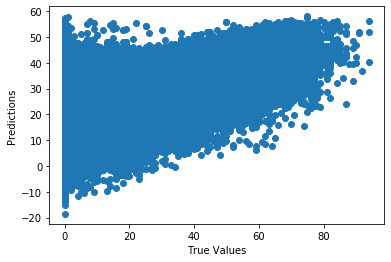

In [17]:
# Plot the model predictions
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Print the accuracy score of the model
print('Score:', model.score(X_test, y_test))

# Print the reduced mean squared error
print('RMSE:', np.sqrt(mse(y_test, y_pred)))

## Ridge Regression

In [13]:
# Build the ridge regression model
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 400, solver = 'cholesky')
model_r = ridge_reg.fit(X_train,y_train)
y_pred = ridge_reg.predict(X_test)

# Print the score of the model
print('Score:', model_r.score(X_test,  y_test))

# Print reduced mean squared error
print('RMSE:', np.sqrt(mse(y_test,y_pred)))

Score: 0.36127484900979334
RMSE: 17.501146715671332


## Lasso Regression

In [14]:
# Build the lasso regression model
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.05)
model_l = lasso_reg.fit(X_train, y_train)
y_pred_l = lasso_reg.predict(X_test)

# Print the score of the model
print('Score:', model_l.score(X_test, y_test))

# Print reduced mean squared error
print('RMSE', np.sqrt(mse(y_test,y_pred)))

Score: 0.3605088694499067
RMSE 17.501146715671332


## Gradient Boosting Regressor

In [16]:
# Build the Gradient Boosting Regressor Model
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.2, validation_fraction = 0.1, n_iter_no_change = 15)
gbr.fit(X_train,y_train)
y_pred = gbr.predict(X_test)

# Print the evaluation on the train set
print('RMSE:', np.sqrt(mse(y_train, gbr.predict(X_train))))

# Print the evaluation on the test set
print('RMSE:', np.sqrt(mse(y_test,y_pred)))

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1348: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.object)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1570: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_mask = np.ones((n_samples, ), dtype=np.bool)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklear

RMSE: 12.818768821108186
RMSE: 13.122368140226394


According to the Gradient Boosting Regressor we are not truly over fitting our data. Overfitting compensates for and tries to make the line of best fit much better than it really is. 

# Conclusions on Reduced Mean Squared Errors
- Linear Regression: 13.12
- Ridge Regression: 17.5
- Lasso Regression: 17.5
- Gradient Boosting Regressor: 13.12

The goal of these models was to reduce the Mean Squared Errors. This allows us to take a look at the variance of the distances of the data points from the line of best fit. 